In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_curve
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

Flat Domain adaptation, one dataset is held out, the model is trained on the remaining four datasets. Prediction is done using the parameters of the dataset that is closest to the held out one.

In [2]:
TRAIN_DIRECTORY = "../.././Data/Combined/"
# TEST_DIRECTORY = "../../../Data/Symptoms/Test/"
coefficients = defaultdict()

In [3]:
def read_file(filename):
    return pd.read_csv(filename)

def get_training_data(files_,training_directory = TRAIN_DIRECTORY):
    data = defaultdict()
    columns = defaultdict()
    for i in files_:
        name = i
        name = name.replace('.csv','')
        data[name] = read_file(training_directory+i)
        columns[name] = list(data[name].columns)
        columns[name].remove('virus')
    return data,columns

In [4]:
def overlap_columns(columns_):
    all_columns = list(columns_.values())
    overlap = list(set(all_columns[0]) & set(all_columns[1]) & set(all_columns[2]) & set(all_columns[3]))
    return overlap
    

In [5]:
def create_columns(columns_):
    overlap = overlap_columns(columns_)
    new_columns = []
    temp = []
    for i in columns_.keys():
        x = [i.replace('.csv','')+'_'+j for j in columns_[i]]
        temp.append(x)
    t = [val for sublist in temp for val in sublist]
    new_columns = t + overlap
    new_columns.append('virus')
    return new_columns

In [6]:
def create_new_dataframe(data,columns):
    new_columns = create_columns(columns)
    new_dataset = defaultdict()
    for i,name in enumerate(data.keys()):
        new_data = pd.DataFrame(columns=new_columns)
        dataset = data[name]
        for j in columns[name]:
            new_data[name+'_'+j] = dataset[j]
            new_data[j] = dataset[j]
        new_data['virus'] = dataset['virus']
        new_data.fillna(0,inplace=True)
        new_dataset[name] = new_data
    #concatenate all the dataframe
    new_dataset = pd.concat(new_dataset.values())
    return new_dataset

In [7]:
def ml_model(dataset):
    lm = linear_model.LogisticRegression()
    x_train = dataset.drop(['virus'],axis = 1)
    y_train = dataset['virus']
    x = lm.fit(x_train,y_train)
    coeff = x.coef_.tolist()[0]
    return lm,coeff

#### Heldout dataset : NYUMC

In [8]:
data = pd.read_csv(TRAIN_DIRECTORY+'nyumc.csv')
data.head()

,fever_sorethroat_age 0-4,fever_sorethroat_age 5-15,fever_sorethroat_age 16-44,fever_sorethroat_age 45-64,fever_sorethroat_age 65+,fever_sorethroat_male,fever_sorethroat_female,fever_cough_age 0-4,fever_cough_age 5-15,fever_cough_age 16-44,...,leg pain_male,leg pain_female,runnynose_age 0-4,runnynose_age 5-15,runnynose_age 16-44,runnynose_age 45-64,runnynose_age 65+,runnynose_male,runnynose_female,virus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
files_nyumc = ['goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_nyumc,columns_nyumc = get_training_data(files_nyumc)

#create the dataframe for domain adaptation
new_dataset_nyumc = create_new_dataframe(data_nyumc,columns_nyumc)

coeff_without_nyumc = ml_model(new_dataset_nyumc)
coefficients['nyumc'] = coeff_without_nyumc

#### Heldout dataset : Goviral

In [10]:
files_goviral = ['nyumc.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_goviral,columns_goviral = get_training_data(files_goviral)
new_dataset_goviral = create_new_dataframe(data_goviral,columns_goviral)

coeff_without_goviral = ml_model(new_dataset_goviral)
coefficients['goviral'] = coeff_without_goviral

#### Heldout dataset : FluWatch

In [11]:
files_fluwatch = ['nyumc.csv','goviral.csv','hongkong.csv','hutterite.csv']
data_fluwatch,columns_fluwatch = get_training_data(files_fluwatch)
new_dataset_fluwatch = create_new_dataframe(data_fluwatch,columns_fluwatch)

coeff_without_fluwatch = ml_model(new_dataset_fluwatch)
coefficients['fluwatch'] = coeff_without_fluwatch

#### Heldout dataset : HongKong

In [12]:
files_hongkong = ['nyumc.csv','goviral.csv','fluwatch.csv','hutterite.csv']
data_hongkong,columns_hongkong = get_training_data(files_hongkong)
new_dataset_hongkong = create_new_dataframe(data_hongkong,columns_hongkong)

coeff_without_hongkong = ml_model(new_dataset_hongkong)
coefficients['hongkong'] = coeff_without_hongkong

#### Heldout dataset : Hutterite

In [13]:
files_hutterite = ['nyumc.csv','goviral.csv','fluwatch.csv','hongkong.csv']
data_hutterite,columns_hutterite = get_training_data(files_hutterite)
new_dataset_hutterite = create_new_dataframe(data_hutterite,columns_hutterite)

coeff_without_hutterite = ml_model(new_dataset_hutterite)
coefficients['hutterite'] = coeff_without_hutterite

#### Model for testing the performance

In [14]:
def test_model(train_data,test_data):
    lm,coeff = ml_model(train_data)
    train = test_data.drop(['virus'],axis = 1)
    test = test_data['virus']
    y_pred = lm.predict(train)
    acc = accuracy_score(test,y_pred)
    fpr,tpr,threshold = roc_curve(test,y_pred)
    auc_score = metrics.auc(fpr,tpr)
    return acc,auc_score
    

#### Prepare data for testing

In [15]:
files_ = ['nyumc.csv','goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']

data_,columns = get_training_data(files_)

In [16]:
def create_data_for_testing(data,name,columns_):
    new_data = pd.DataFrame(columns = columns_)
    columns_for_data = list(data.columns)
    col = [x for x in columns_for_data if x != 'virus']
    for i in col:
        new_data[name+'_'+i] = data[i]
        new_data[i] = data[i]
    new_data['virus'] = data['virus']
    new_data.fillna(0,inplace = True)
    return new_data

In [17]:
def test_against_all(dataset_name,to_be_tested_names,data_,original_data,store_):
    columns = list(original_data.columns)
    data = data_[dataset_name]
    for i in to_be_tested_names:
        temp_data = create_data_for_testing(data,i,columns)
        acc,auc_score = test_model(original_data,temp_data)
        print("Comparing against ",i)
        print("Accuracy : ",acc)
        print("Auc Score : ",auc_score)
        print("____________________________")
        store_[i] = auc_score
    return store_

#### Test NYUMC

In [18]:
store_nyumc = defaultdict()
print("Testing NYUMC Data!\n")
store_nyumc = test_against_all('nyumc',['goviral','fluwatch','hongkong','hutterite'],data_,new_dataset_nyumc,store_nyumc)

Testing NYUMC Data!

Comparing against  goviral
Accuracy :  0.440270233259
Auc Score :  0.411295796731
____________________________
Comparing against  fluwatch
Accuracy :  0.440270233259
Auc Score :  0.411295796731
____________________________
Comparing against  hongkong
Accuracy :  0.438855160451
Auc Score :  0.424520819506
____________________________
Comparing against  hutterite
Accuracy :  0.317295841512
Auc Score :  0.311104676016
____________________________


In [19]:
store_nyumc

defaultdict(None,
            {'fluwatch': 0.4112957967310521,
             'goviral': 0.4112957967310521,
             'hongkong': 0.42452081950586151,
             'hutterite': 0.31110467601576469})

#### Test Goviral

In [20]:
store_gv = defaultdict()
print("Testing Goviral data!\n")
store_gv = test_against_all('goviral',['nyumc','fluwatch','hongkong','hutterite'],data_,new_dataset_goviral,store_gv)

Testing Goviral data!

Comparing against  nyumc
Accuracy :  0.528846153846
Auc Score :  0.534682765152
____________________________
Comparing against  fluwatch
Accuracy :  0.826923076923
Auc Score :  0.827947443182
____________________________
Comparing against  hongkong
Accuracy :  0.651923076923
Auc Score :  0.652994791667
____________________________
Comparing against  hutterite
Accuracy :  0.580769230769
Auc Score :  0.585404829545
____________________________


In [21]:
store_gv

defaultdict(None,
            {'fluwatch': 0.82794744318181812,
             'hongkong': 0.65299479166666674,
             'hutterite': 0.58540482954545459,
             'nyumc': 0.53468276515151514})

#### Test Fluwatch

In [22]:
store_fw = defaultdict()
print("Testing FluWatch data!\n")
store_fw = test_against_all('fluwatch',['nyumc','goviral','hongkong','hutterite'],data_,new_dataset_fluwatch,store_fw)

Testing FluWatch data!

Comparing against  nyumc
Accuracy :  0.528846153846
Auc Score :  0.534682765152
____________________________
Comparing against  goviral
Accuracy :  0.826923076923
Auc Score :  0.827947443182
____________________________
Comparing against  hongkong
Accuracy :  0.651923076923
Auc Score :  0.652994791667
____________________________
Comparing against  hutterite
Accuracy :  0.580769230769
Auc Score :  0.585404829545
____________________________


In [23]:
store_fw

defaultdict(None,
            {'goviral': 0.82794744318181812,
             'hongkong': 0.65299479166666674,
             'hutterite': 0.58540482954545459,
             'nyumc': 0.53468276515151514})

#### Test Hongkong

In [24]:
store_hk = defaultdict()
print("Testing Hongkong!\n")
store_hk = test_against_all('hongkong',['nyumc','goviral','fluwatch','hutterite'],data_,new_dataset_hongkong,store_hk)

Testing Hongkong!

Comparing against  nyumc
Accuracy :  0.719014937424
Auc Score :  0.578436040631
____________________________
Comparing against  goviral
Accuracy :  0.787444489302
Auc Score :  0.692393449729
____________________________
Comparing against  fluwatch
Accuracy :  0.787444489302
Auc Score :  0.692393449729
____________________________
Comparing against  hutterite
Accuracy :  0.805611626968
Auc Score :  0.751081412615
____________________________


In [25]:
store_hk

defaultdict(None,
            {'fluwatch': 0.69239344972930095,
             'goviral': 0.69239344972930095,
             'hutterite': 0.75108141261540451,
             'nyumc': 0.57843604063098542})

#### Test hutterite

In [26]:
store_ht = defaultdict()
print("Testing hutterite!\n")
store_ht = test_against_all('hutterite',['nyumc','goviral','fluwatch','hongkong'],data_,new_dataset_hutterite,store_ht)

Testing hutterite!

Comparing against  nyumc
Accuracy :  0.538641686183
Auc Score :  0.568720291147
____________________________
Comparing against  goviral
Accuracy :  0.561280249805
Auc Score :  0.573703951277
____________________________
Comparing against  fluwatch
Accuracy :  0.561280249805
Auc Score :  0.573703951277
____________________________
Comparing against  hongkong
Accuracy :  0.60031225605
Auc Score :  0.595829619727
____________________________


In [27]:
store_ht

defaultdict(None,
            {'fluwatch': 0.57370395127748064,
             'goviral': 0.57370395127748064,
             'hongkong': 0.59582961972667858,
             'nyumc': 0.5687202911467617})

In [28]:
results = defaultdict()
results['nyumc'] = store_nyumc
results['govial'] = store_gv
results['fluwatch'] = store_fw
results['hongkong'] = store_hk
results['hutterite'] = store_ht

In [29]:
def create_plots(columns,dict_,name,order,label,title):
    df = pd.DataFrame(columns)
    df_list = []
    for i in dict_.keys():
        df_list.append(pd.DataFrame({k:[v] for (k,v) in dict(dict_[i]).items()}))
    df = pd.concat(df_list)
#     df.fillna(0,inplace = True)
    df[name] = columns
    df.set_index(name,inplace = True)
    df = df[order]
    sns.set()
    ax = plt.axes()
    sns.heatmap(df,annot=True,linewidth = 0.8,ax = ax,cbar_kws = {'label' : label},fmt = 'f')
    ax.set_title(title)
    ax.set_xlabel('Dataset')
    plt.show()
    return df
    

In [30]:
results

defaultdict(None,
            {'fluwatch': defaultdict(None,
                         {'goviral': 0.82794744318181812,
                          'hongkong': 0.65299479166666674,
                          'hutterite': 0.58540482954545459,
                          'nyumc': 0.53468276515151514}),
             'govial': defaultdict(None,
                         {'fluwatch': 0.82794744318181812,
                          'hongkong': 0.65299479166666674,
                          'hutterite': 0.58540482954545459,
                          'nyumc': 0.53468276515151514}),
             'hongkong': defaultdict(None,
                         {'fluwatch': 0.69239344972930095,
                          'goviral': 0.69239344972930095,
                          'hutterite': 0.75108141261540451,
                          'nyumc': 0.57843604063098542}),
             'hutterite': defaultdict(None,
                         {'fluwatch': 0.57370395127748064,
                          'goviral': 0.5737039

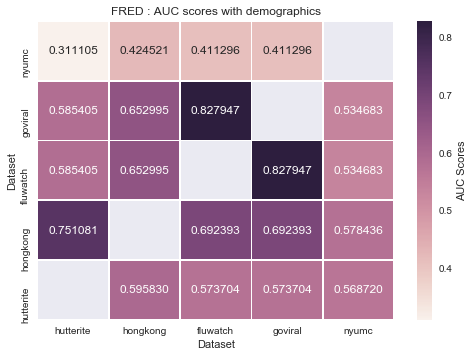

In [31]:
nyumc = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'], 
                     results, 
                     'Dataset',
                     ['hutterite','hongkong','fluwatch','goviral','nyumc'],'AUC Scores','FRED : AUC scores with demographics')

#### Get the distance between the datasets

In [32]:
directory = "../../../Data/with_Improved_Target/With_Demographics/"

In [33]:
data_,columns = get_training_data(files_,directory)

In [34]:
def only_positive_data_stats(data_dict):
    data_stats = defaultdict()
    for i in data_dict.keys():
        data = data_dict[i]
        data = data.loc[data['virus'] == 1]
        data_stats[i] = data.var(axis = 0)
    return data_stats

In [35]:
positive_data_stats = only_positive_data_stats(data_)

In [36]:
#l2 distance
def get_distance(data_stats):

    distance = defaultdict()
    names = list(data_stats)
    for i in names:
        compare_to = [j for j in names if j!=i]
        distance[i] = [(j,np.linalg.norm((np.asarray(data_stats[i]) - np.asarray(data_stats[j])),ord = 2)) for j in compare_to]
    return distance


In [37]:
positive_distance = get_distance(positive_data_stats)

In [38]:
positive_distance

defaultdict(None,
            {'fluwatch': [('nyumc', 0.556502756341136),
              ('goviral', 0.62881845210175569),
              ('hongkong', 0.46405305720202134),
              ('hutterite', 0.39164420867674749)],
             'goviral': [('nyumc', 0.59163991895513557),
              ('fluwatch', 0.62881845210175569),
              ('hongkong', 0.62979792004225621),
              ('hutterite', 0.54924266199243521)],
             'hongkong': [('nyumc', 0.50005295319913701),
              ('goviral', 0.62979792004225621),
              ('fluwatch', 0.46405305720202134),
              ('hutterite', 0.38121262202623807)],
             'hutterite': [('nyumc', 0.51609878714312574),
              ('goviral', 0.54924266199243521),
              ('fluwatch', 0.39164420867674749),
              ('hongkong', 0.38121262202623807)],
             'nyumc': [('goviral', 0.59163991895513557),
              ('fluwatch', 0.556502756341136),
              ('hongkong', 0.50005295319913701),
       

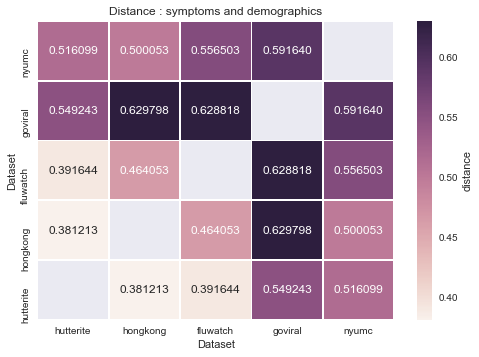

In [39]:
positive_distances = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'],
                  positive_distance,
                  'Dataset',
                  ['hutterite','hongkong','fluwatch','goviral','nyumc'],'distance',
                  'Distance : symptoms and demographics')